In [1]:
# @title Loading libraries
import pandas as pd
import numpy as np
# import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree, DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay



c:\Users\syeda.fatima\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import pandas as pd

df = pd.read_csv('youth_data.csv')
df.columns = df.columns.str.upper()
df.head()

IRALCFY  IRMJFY  IRCIGFM  IRSMKLSS30N  IRALCFM  IRMJFM  IRCIGAGE  \
0      993     991       91           91     93.0    91.0       991   
1      991     991       91           91     91.0    91.0       991   
2      993     993       93           91     93.0    93.0        13   
3      991     991       91           91     91.0    91.0       991   
4      991     991       91           91     91.0    91.0       991   

   IRSMKLSSTRY  IRALCAGE  IRMJAGE  ...  EDUSCHLGO  EDUSCHGRD2  EDUSKPCOM  \
0          991        12      991  ...          1           5          0   
1          991       991      991  ...          1           5          0   
2          991        13       13  ...          1           4          0   
3          991       991      991  ...          1           7          0   
4          991       991      991  ...          1           3          0   

   IMOTHER  IFATHER  INCOME  GOVTPROG  POVERTY3  PDEN10  COUTYP4  
0        1        1       4         2         3       2        2  
1        1        1       4         2         3       1        1  
2        1        1       4         1         3       1        1  
3        1        1       2         2         1       2        2  
4        1        1       4         2         3       2        2  

[5 rows x 79 columns]

In [3]:
# missing values in each column
missing_values = df.isnull().sum()
# print(missing_values[missing_values > 0])

In [4]:
# dropping rows null values from youth experiences columns.
youth_exp_indicators = ['AVGGRADE', 'ARGUPAR', 'SCHFELT', 'TCHGJOB', 'STNDSCIG', 'STNDSMJ', 'STNDALC',
                   'STNDDNK', 'PARCHKHW', 'PARHLPHW', 'PRCHORE2', 'PRLMTTV2', 'PARLMTSN', 
                   'PRGDJOB2', 'PRPROUD2', 'YOFIGHT2', 'YOGRPFT2', 'YOHGUN2', 'YOSELL2', 
                   'YOSTOLE2', 'YOATTAK2', 'PRPKCIG2', 'PRMJEVR2', 'PRMJMO','PRALDLY2', 'YFLPKCG2',
                     'YFLTMRJ2', 'YFLMJMO', 'YFLADLY2', 'FRDPCIG2', 'FRDMEVR2', 'FRDMJMON', 'FRDADLY2', 
                     'TALKPROB', 'PRTALK3', 'PRBSOLV2', 'PREVIOL2', 'PRVDRGO2', 'GRPCNSL2', 'PREGPGM2', 
                     'YTHACT2', 'DRPRVME3', 'ANYEDUC3', 'RLGATTD', 'RLGIMPT', 'RLGDCSN', 'RLGFRND']

df.dropna(subset=youth_exp_indicators, inplace=True)
df.shape

(4269, 79)

In [5]:
# dropping rows where ifather or imother is 3,4 meaning the youth is either 18 or the response was "don't know" 
# same with eduschgrd2, eduskcom, droppping rows where response was legitimately skipped or not answered
# pden10 is fitered to consider responses from densely populated areas or urban areas

df = (
    df[~df['IMOTHER'].isin([3, 4])]
    [~df['IFATHER'].isin([3, 4])]
    [~df['EDUSCHGRD2'].isin([98, 99])]
    [~df['EDUSKPCOM'].isin([94, 97, 98, 99])]
    [df['PDEN10'] != 3]
).reset_index(drop=True)

df.shape

C:\Users\syeda.fatima\AppData\Local\Temp\ipykernel_4988\3931605009.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[~df['IMOTHER'].isin([3, 4])]
C:\Users\syeda.fatima\AppData\Local\Temp\ipykernel_4988\3931605009.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[~df['IMOTHER'].isin([3, 4])]
C:\Users\syeda.fatima\AppData\Local\Temp\ipykernel_4988\3931605009.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[~df['IMOTHER'].isin([3, 4])]
C:\Users\syeda.fatima\AppData\Local\Temp\ipykernel_4988\3931605009.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[~df['IMOTHER'].isin([3, 4])]


(3168, 79)

In [6]:
demographic_indicators = ['IRSEX', 'NEWRACE2', 'HEALTH2', 'EDUSCHLGO', 'EDUSCHGRD2', 'EDUSKPCOM', 
                    'IMOTHER', 'IFATHER', 'INCOME', 'GOVTPROG', 'POVERTY3', 'PDEN10', 'COUTYP4']


Binary classification

In [7]:
required_columns = demographic_indicators + youth_exp_indicators + ['ALCFLAG']
df_b = df[required_columns]

print(df_b.shape)

(3168, 61)


# preparing data

In [8]:
X = df_b.drop('ALCFLAG', axis=1)
y = df_b['ALCFLAG']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# decision tree model

In [9]:
tree = DecisionTreeClassifier(random_state=1)
tree.fit(X_train, y_train)

accuracy = tree.score(X_test, y_test)
print("Accuracy of decision tree model: {:.2f}%".format(accuracy*100))

Accuracy of decision tree model: 72.24%


In [10]:
features_importance = pd.DataFrame({'feature_name': X_train.columns, 'importance': tree.feature_importances_})
features_importance = features_importance.sort_values('importance', ascending=False).reset_index(drop=True)
features_importance.head(10)

feature_name  importance
0      YFLMJMO    0.200715
1      STNDALC    0.084447
2   EDUSCHGRD2    0.059864
3     NEWRACE2    0.032205
4      HEALTH2    0.029403
5       INCOME    0.025132
6        IRSEX    0.024186
7      SCHFELT    0.021946
8    EDUSKPCOM    0.021881
9     PRBSOLV2    0.020175

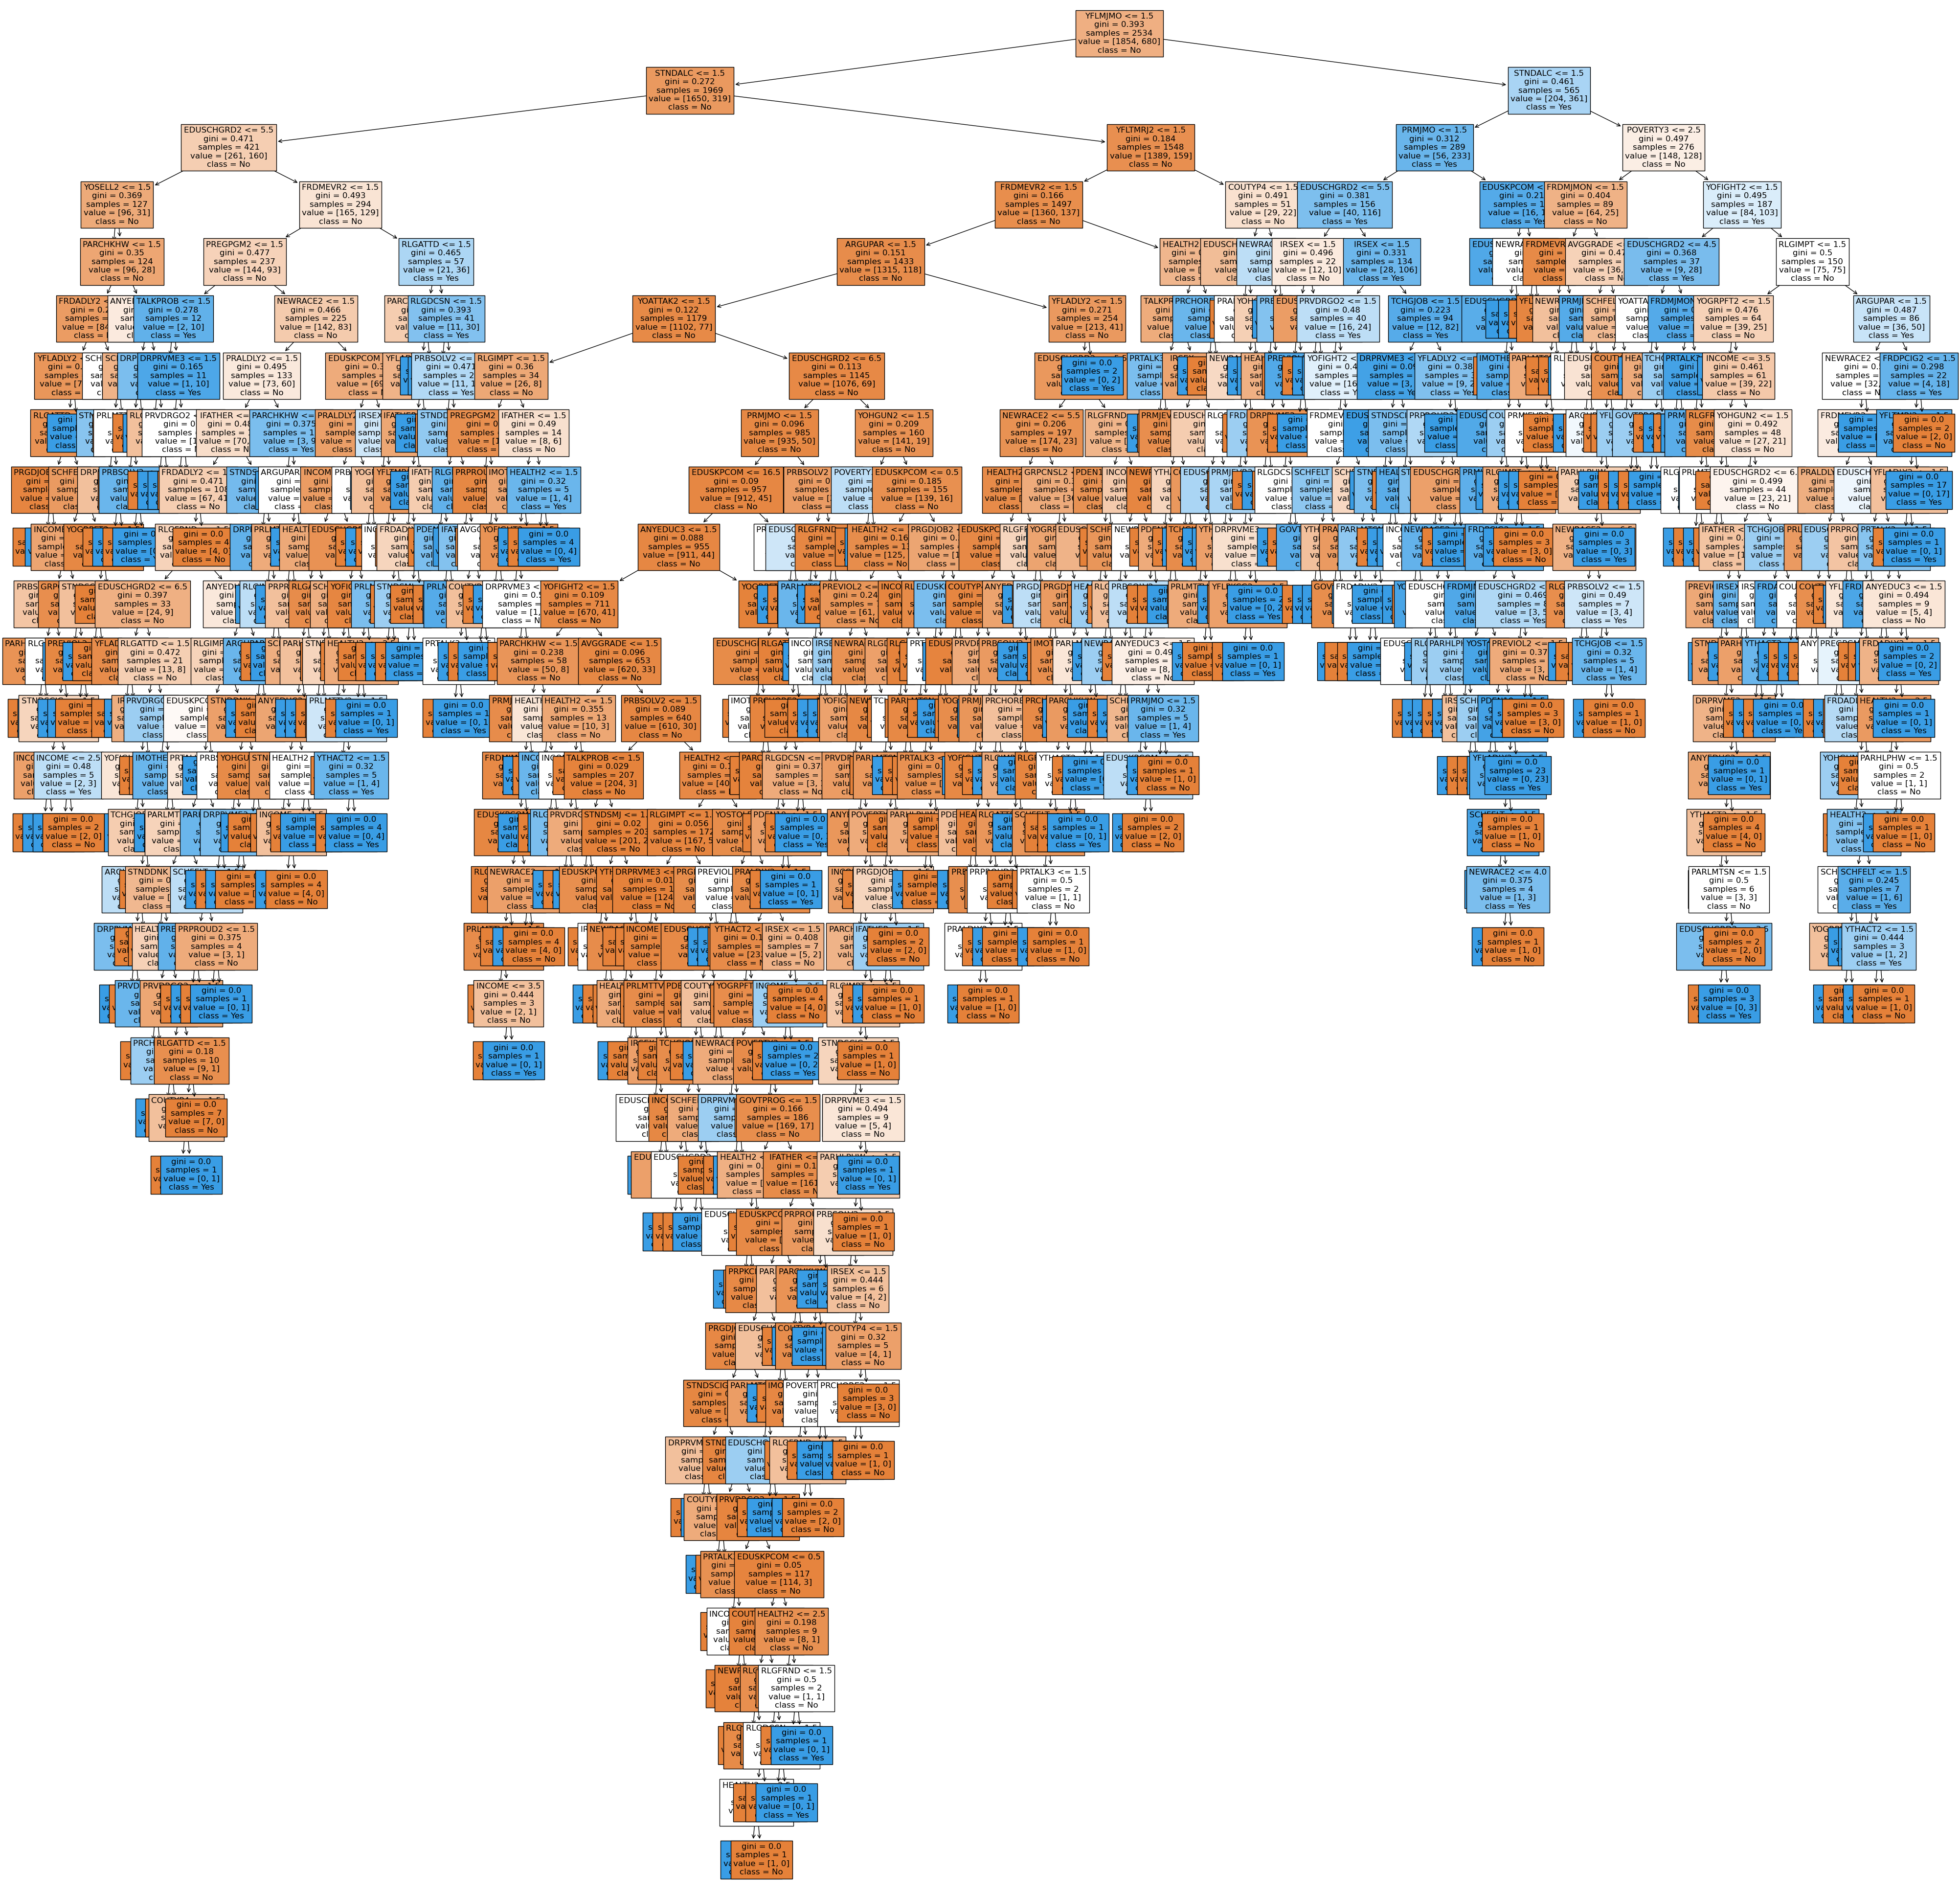

In [11]:
plt.figure(figsize=(50,50))
plot_tree(tree
          , filled=True
          , feature_names=X_train.columns
          , class_names=['No', 'Yes']
          , label='all'
          , fontsize=12)
plt.show()

 The high number of nodes and branches indicates that the model is likely overfitting

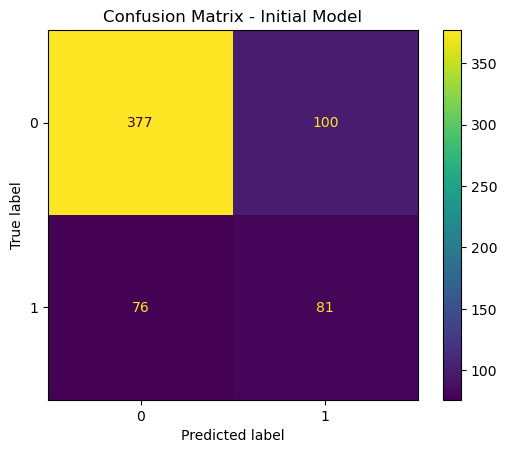

In [12]:
y_pred_tree = tree.predict(X_test)

tree_cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_tree))
tree_cm.plot()
plt.title("Confusion Matrix - Initial Model")
plt.show()

# Pruned tree

Let's try pruning by fiding optimal size of the tree

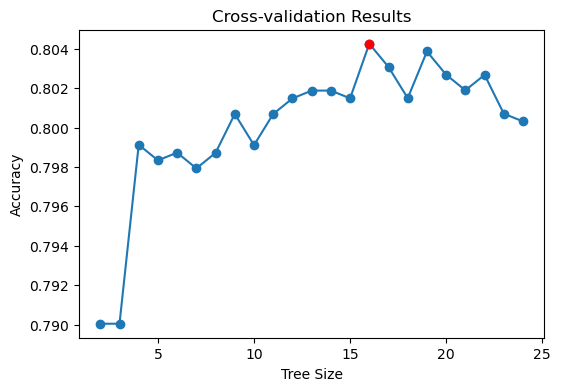

In [13]:
tree_ = DecisionTreeClassifier(random_state=1)
tree_.fit(X_train, y_train)

params = {'max_leaf_nodes': range(2, 25)}  
cv = GridSearchCV(tree_, params, cv=10)
cv.fit(X_train, y_train)
cv_results = cv.cv_results_
best_size = cv.best_params_['max_leaf_nodes']
best_score = cv.best_score_

plt.figure(figsize=(6, 4))
plt.plot(cv_results["param_max_leaf_nodes"], cv_results["mean_test_score"], 'o-')
plt.plot(best_size, best_score, 'ro-')
plt.xlabel('Tree Size')
plt.ylabel('Accuracy')
plt.title('Cross-validation Results');

In [14]:
print('Best tree size', best_size)


Best tree size 16


stable and consistent increase in accuracy with tree size around 15-16

In [15]:
# prune tree with the optimal size
prune_tree = DecisionTreeClassifier(max_leaf_nodes=15, random_state=1)
prune_tree.fit(X_train, y_train)

accuracy = prune_tree.score(X_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 79.18%


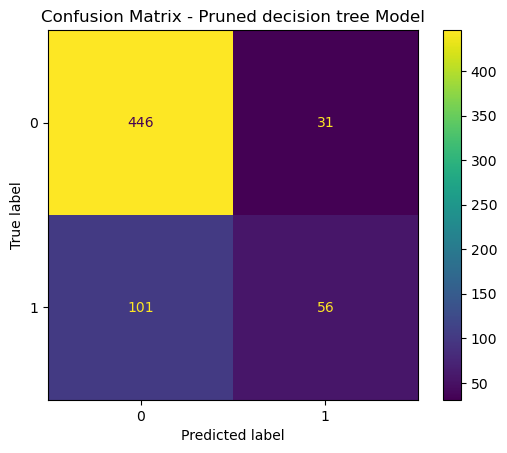

In [16]:
y_pred_prune = prune_tree.predict(X_test)
prune_cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_prune))
prune_cm.plot()
plt.title("Confusion Matrix - Pruned decision tree Model")
plt.show()

In [17]:
features_importance = pd.DataFrame({'feature_name': X_train.columns, 'importance': prune_tree.feature_importances_})
features_importance = features_importance.sort_values('importance', ascending=False).reset_index(drop=True)
features_importance.head(10)

feature_name  importance
0      YFLMJMO    0.575321
1      STNDALC    0.242056
2     YFLTMRJ2    0.032819
3     FRDMEVR2    0.031388
4     POVERTY3    0.025308
5   EDUSCHGRD2    0.019366
6     PREGPGM2    0.014158
7     NEWRACE2    0.012674
8     AVGGRADE    0.012551
9     FRDMJMON    0.011966

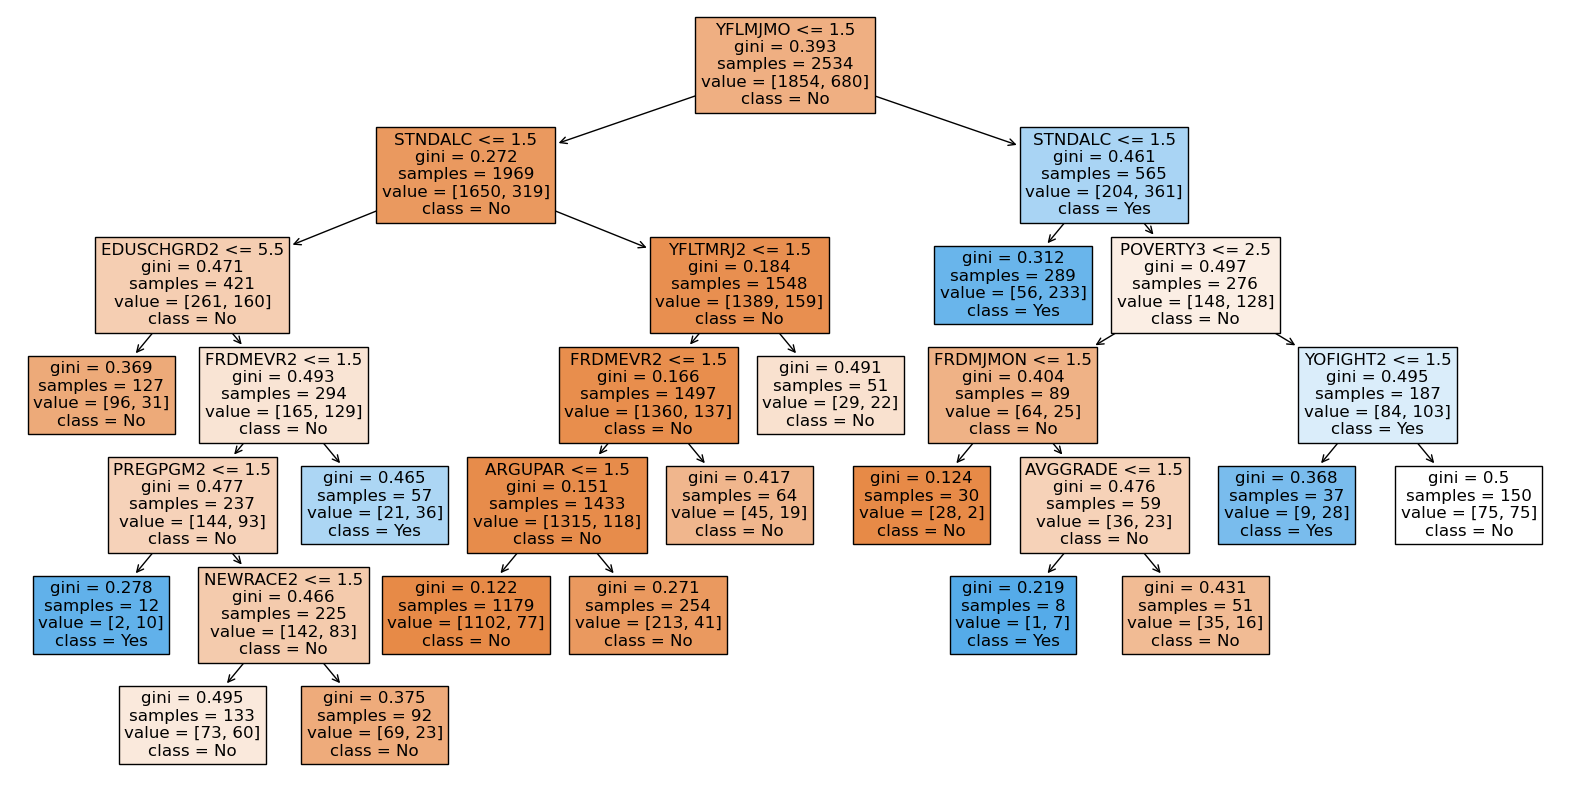

In [18]:
plt.figure(figsize=(20,10))
plt.title('Pruned Tree')
plot_tree(prune_tree
          , filled=True
          , feature_names=X_train.columns
          , class_names=['No', 'Yes']
          , label='all'
          , fontsize=12)
plt.show()

# Random Forest

finding optimal number of features to use

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_features': [5, 10, 15, 20, 'auto', 'sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=1)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best max_features parameter:", best_params['max_features'])


c:\Users\syeda.fatima\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\syeda.fatima\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\syeda.fatima\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also t

Best max_features parameter: 5


In [23]:
rf = RandomForestClassifier(max_features=5 , random_state = 1)
rf.fit(X_train,y_train)

RandomForestClassifier(max_features=5, random_state=1)

In [24]:
y_pred_rf = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 81.39%


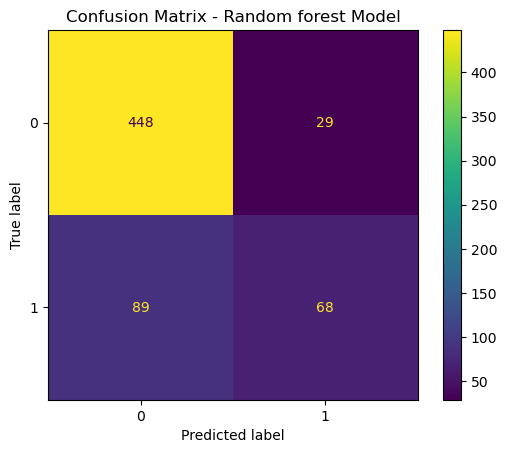

In [25]:
rf_cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_rf))
rf_cm.plot()
plt.title("Confusion Matrix - Random forest Model")
plt.show()

In [26]:
features_importance = pd.DataFrame({'feature_name': X_train.columns, 'importance': rf.feature_importances_})
features_importance = features_importance.sort_values('importance', ascending=False).reset_index(drop=True)
features_importance.head(10)

feature_name  importance
0   EDUSCHGRD2    0.065209
1      STNDALC    0.061133
2      YFLMJMO    0.052227
3     YFLTMRJ2    0.051950
4     FRDMEVR2    0.038117
5     FRDMJMON    0.033416
6      HEALTH2    0.028782
7     NEWRACE2    0.028071
8      STNDSMJ    0.027839
9       INCOME    0.024851

# Bagging

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Best max_features and max_depth values found earlier
best_max_features = 20
best_max_depth = 15

param_grid = {
    'n_estimators': [50, 100, 200],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(max_features=best_max_features, max_depth=best_max_depth, random_state=1)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation accuracy: {:.2f}%".format(best_score * 100))

Best parameters found:  {'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 81.02%


In [28]:

# Train the model with the best parameters
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

print("Number of trees:", best_rf.n_estimators)
print("Number of features tried at each split:", best_rf.max_features)
print("Training score: {:.2f}%".format(best_rf.score(X_train, y_train) * 100))

# Predict on the test data
y_pred = best_rf.predict(X_test)

# Calculate the accuracy of the tuned classifier
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy: {:.2f}%".format(accuracy * 100))


Number of trees: 100
Number of features tried at each split: 20
Training score: 93.33%
Test accuracy: 80.91%


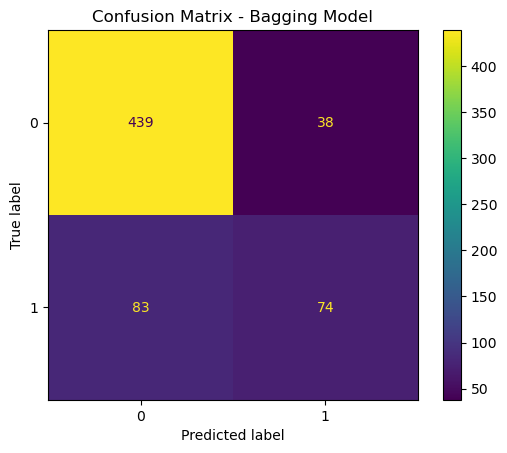

In [29]:
bag = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
bag.plot()
plt.title("Confusion Matrix - Bagging Model")
plt.show()

# Boosting

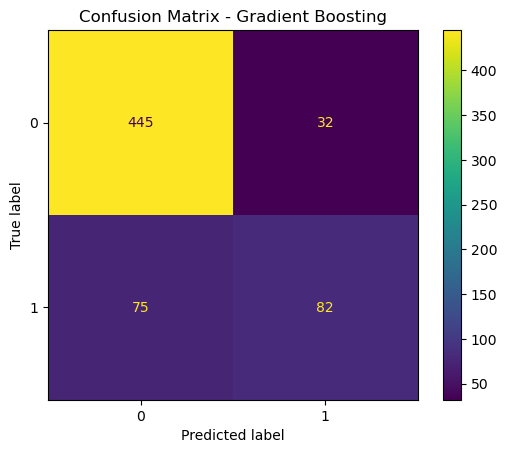

Accuracy: 83.12%


In [30]:
from sklearn.ensemble import GradientBoostingClassifier

boosting_model = GradientBoostingClassifier(random_state=1)
boosting_model.fit(X_train, y_train)

y_pred_boosting = boosting_model.predict(X_test)

cm_boosting = confusion_matrix(y_test, y_pred_boosting)

boost_cm = ConfusionMatrixDisplay(confusion_matrix=cm_boosting)
boost_cm.plot()
plt.title("Confusion Matrix - Gradient Boosting")
plt.show()

accuracy_boosting = accuracy_score(y_test, y_pred_boosting)
print("Accuracy: {:.2f}%".format(accuracy_boosting * 100))


# Multi Class Classification

In [32]:
required_columns = demographic_indicators + youth_exp_indicators + ['ALCYDAYS']
df_m = df[required_columns]
print(df_m.shape)

(3168, 61)


In [33]:
df_m['ALCYDAYS'].value_counts()

ALCYDAYS
6    2488
1     420
2     169
3      54
4      37
Name: count, dtype: int64

In [34]:
df_m['ALCYDAYS'] = df_m['ALCYDAYS'].replace({6: 0})

df_m['ALCYDAYS'].value_counts()

C:\Users\syeda.fatima\AppData\Local\Temp\ipykernel_4988\2676369564.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_m['ALCYDAYS'] = df_m['ALCYDAYS'].replace({6: 0})


ALCYDAYS
0    2488
1     420
2     169
3      54
4      37
Name: count, dtype: int64

In [35]:
X = df_m.drop('ALCYDAYS', axis=1)
y = df_m['ALCYDAYS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

decision tree

In [36]:
tree_m = DecisionTreeClassifier(random_state=1)
tree_m.fit(X_train, y_train)

accuracy = tree_m.score(X_test, y_test)
print("Accuracy of decision tree model: {:.2f}%".format(accuracy*100))

Accuracy of decision tree model: 68.45%


In [37]:
features_importance = pd.DataFrame({'feature_name': X_train.columns, 'importance': tree_m.feature_importances_})
features_importance = features_importance.sort_values('importance', ascending=False).reset_index(drop=True)
features_importance.head(10)

feature_name  importance
0      YFLMJMO    0.129249
1   EDUSCHGRD2    0.053089
2      STNDALC    0.048591
3    EDUSKPCOM    0.039582
4       INCOME    0.029488
5      COUTYP4    0.028077
6     NEWRACE2    0.025900
7      HEALTH2    0.024369
8      TCHGJOB    0.023792
9      RLGATTD    0.021468

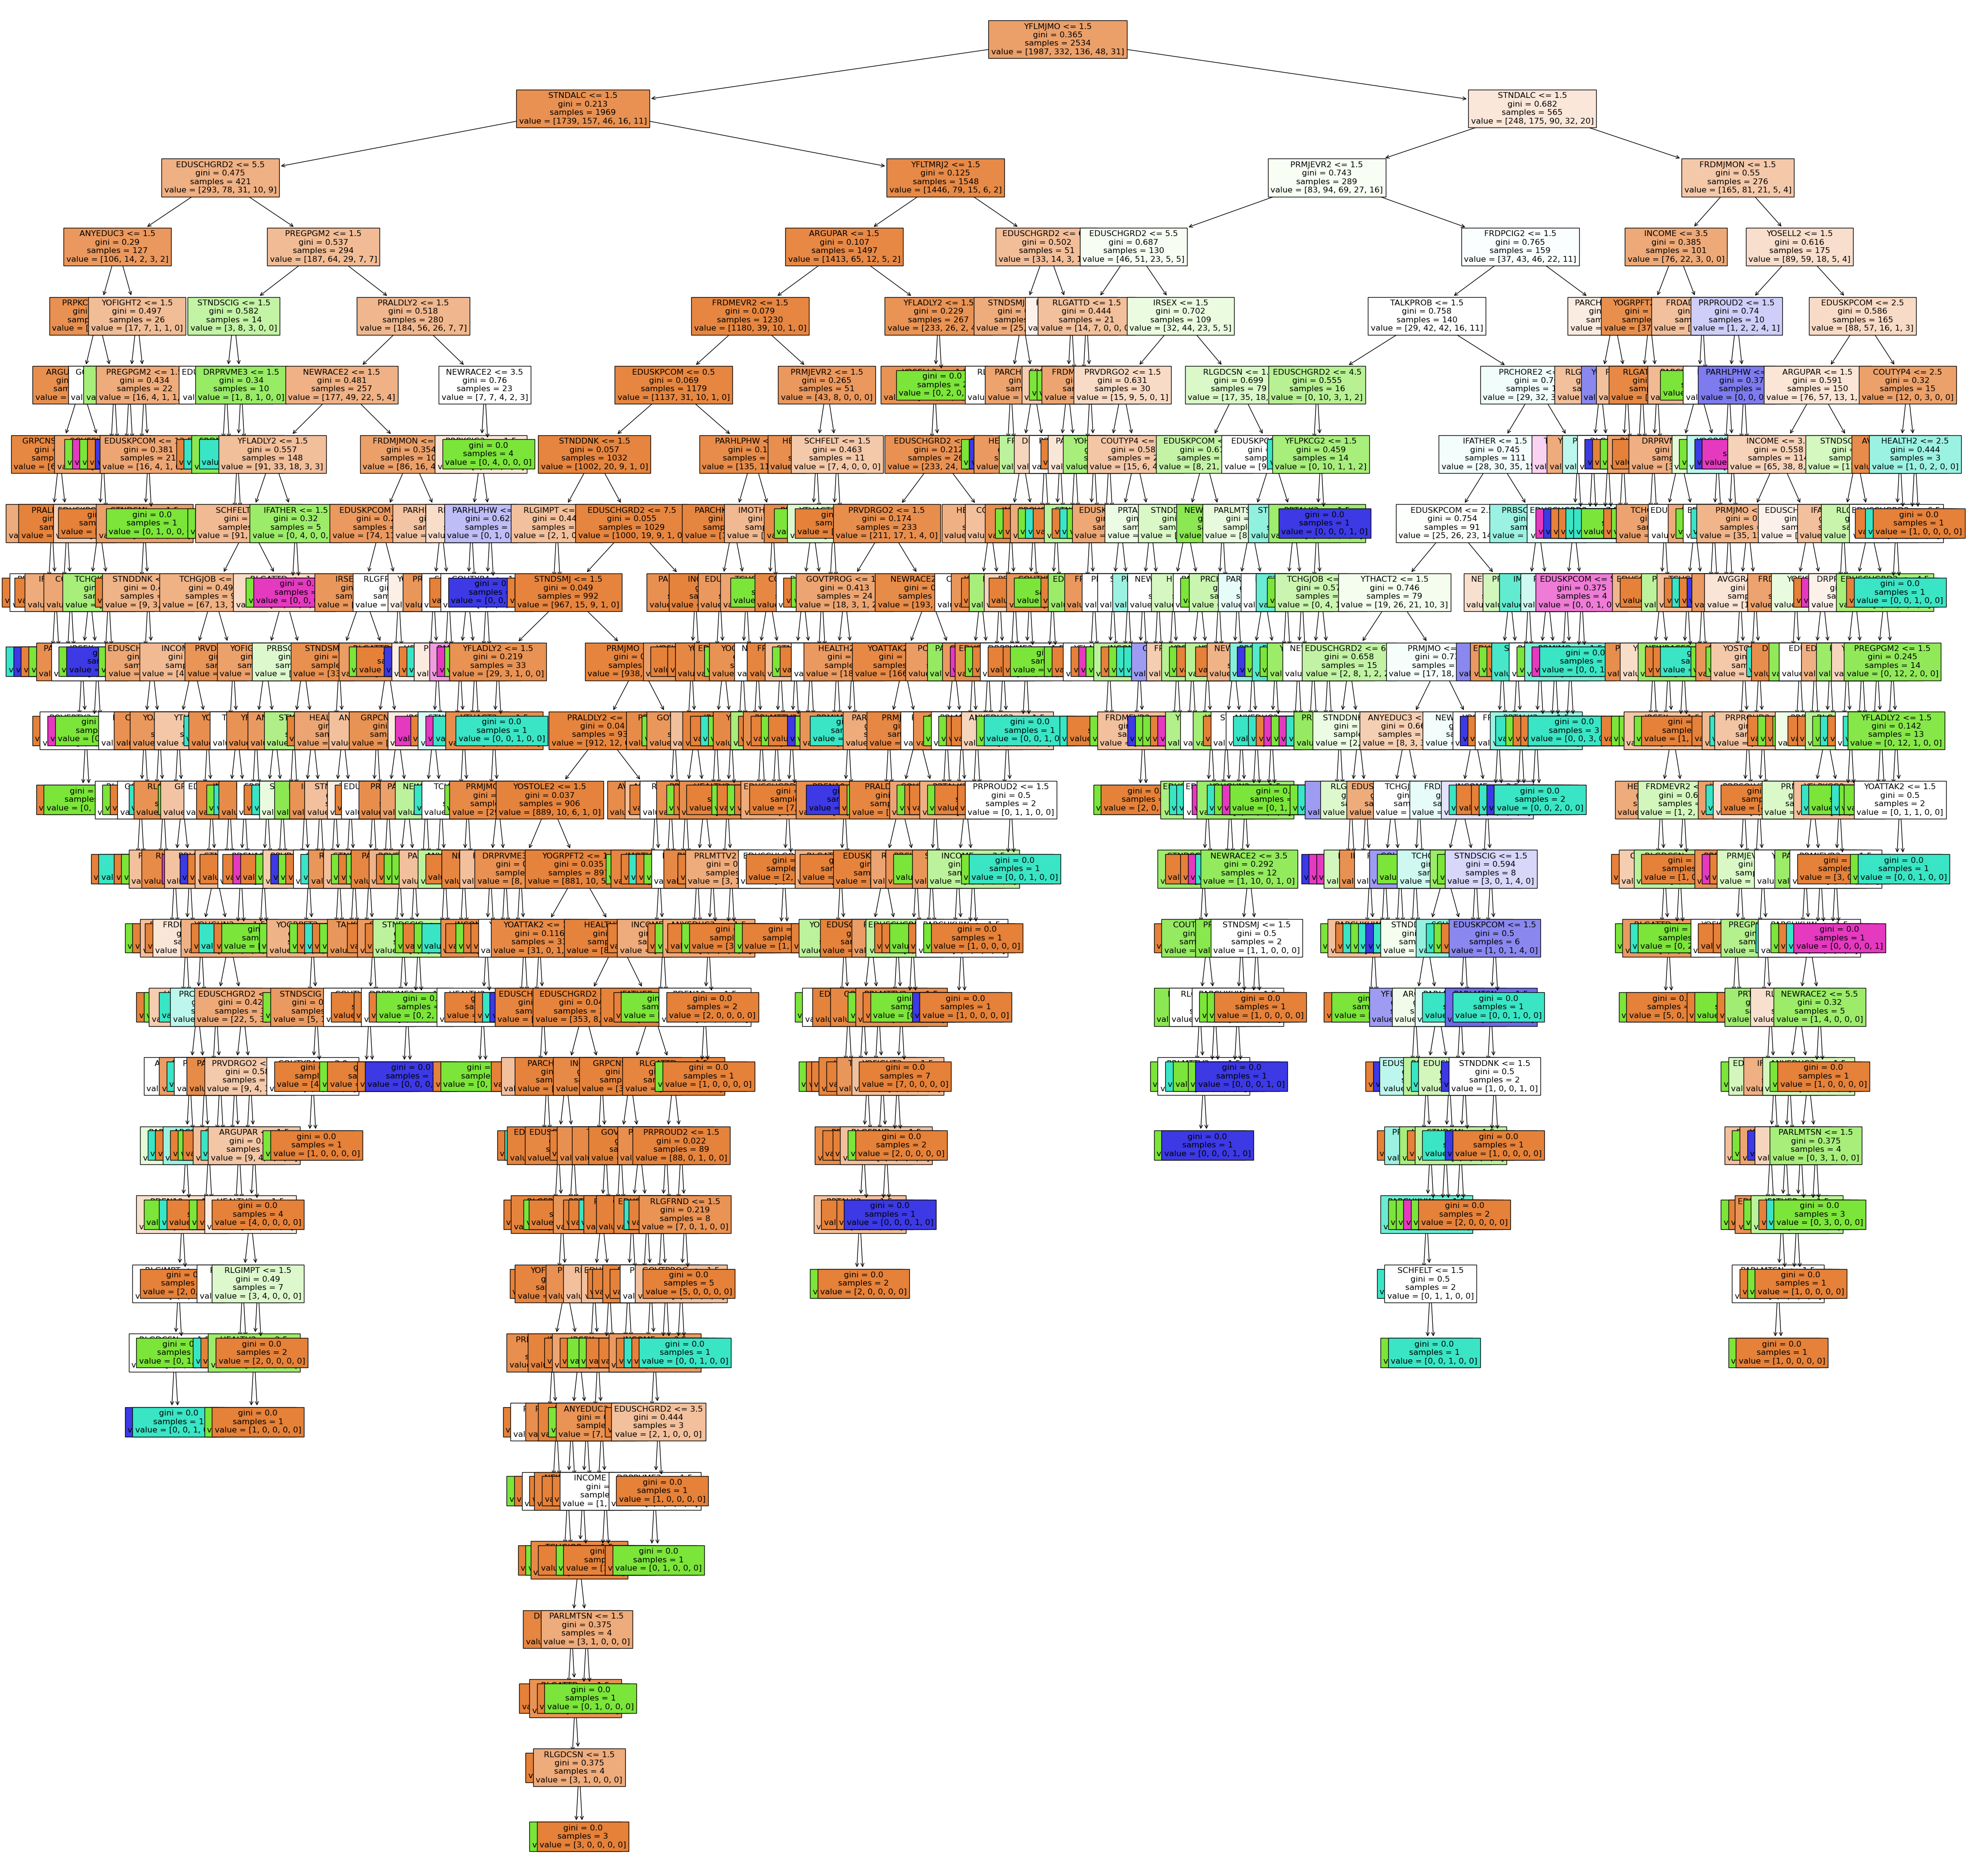

In [40]:
plt.figure(figsize=(50,50))
plot_tree(tree_m
          , filled=True
          , feature_names=X_train.columns
          , label='all'
          , fontsize=12)
plt.show()

pruned

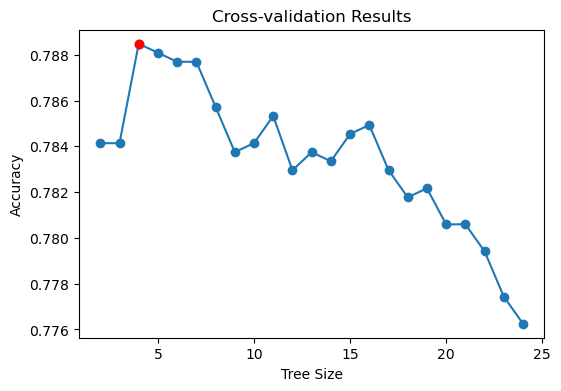

In [ ]:
tree_m = DecisionTreeClassifier(random_state=1)
tree_m.fit(X_train, y_train)

params = {'max_leaf_nodes': range(2, 25)}  
cv = GridSearchCV(tree_, params, cv=10)
cv.fit(X_train, y_train)
cv_results = cv.cv_results_
best_size = cv.best_params_['max_leaf_nodes']
best_score = cv.best_score_

plt.figure(figsize=(6, 4))
plt.plot(cv_results["param_max_leaf_nodes"], cv_results["mean_test_score"], 'o-')
plt.plot(best_size, best_score, 'ro-')
plt.xlabel('Tree Size')
plt.ylabel('Accuracy')
plt.title('Cross-validation Results');

In [ ]:
print('Best tree size', best_size)

Best tree size 4


In [ ]:
# prune tree with the optimal size
prune_tree_m = DecisionTreeClassifier(max_leaf_nodes=4, random_state=1)
prune_tree_m.fit(X_train, y_train)

accuracy = prune_tree_m.score(X_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 79.50%


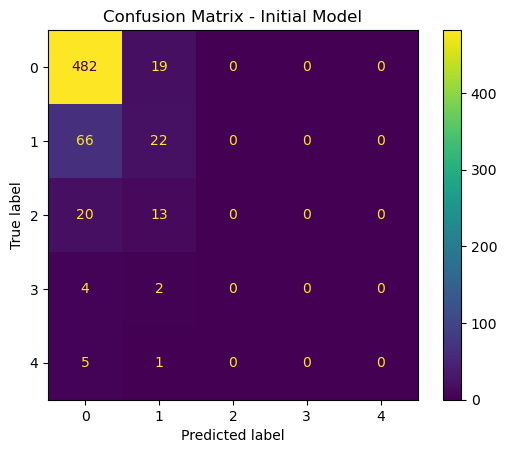

In [ ]:
y_pred_prune = prune_tree_m.predict(X_test)
prune_cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_prune))
prune_cm.plot()
plt.title("Confusion Matrix - Initial Model")
plt.show()

In [ ]:
features_importance = pd.DataFrame({'feature_name': X_train.columns, 'importance': prune_tree_m.feature_importances_})
features_importance = features_importance.sort_values('importance', ascending=False).reset_index(drop=True)
features_importance.head(10)

feature_name  importance
0      YFLMJMO     0.72677
1      STNDALC     0.27323
2        IRSEX     0.00000
3      YOSELL2     0.00000
4     YOATTAK2     0.00000
5     PRPKCIG2     0.00000
6     PRMJEVR2     0.00000
7       PRMJMO     0.00000
8     PRALDLY2     0.00000
9     YFLPKCG2     0.00000

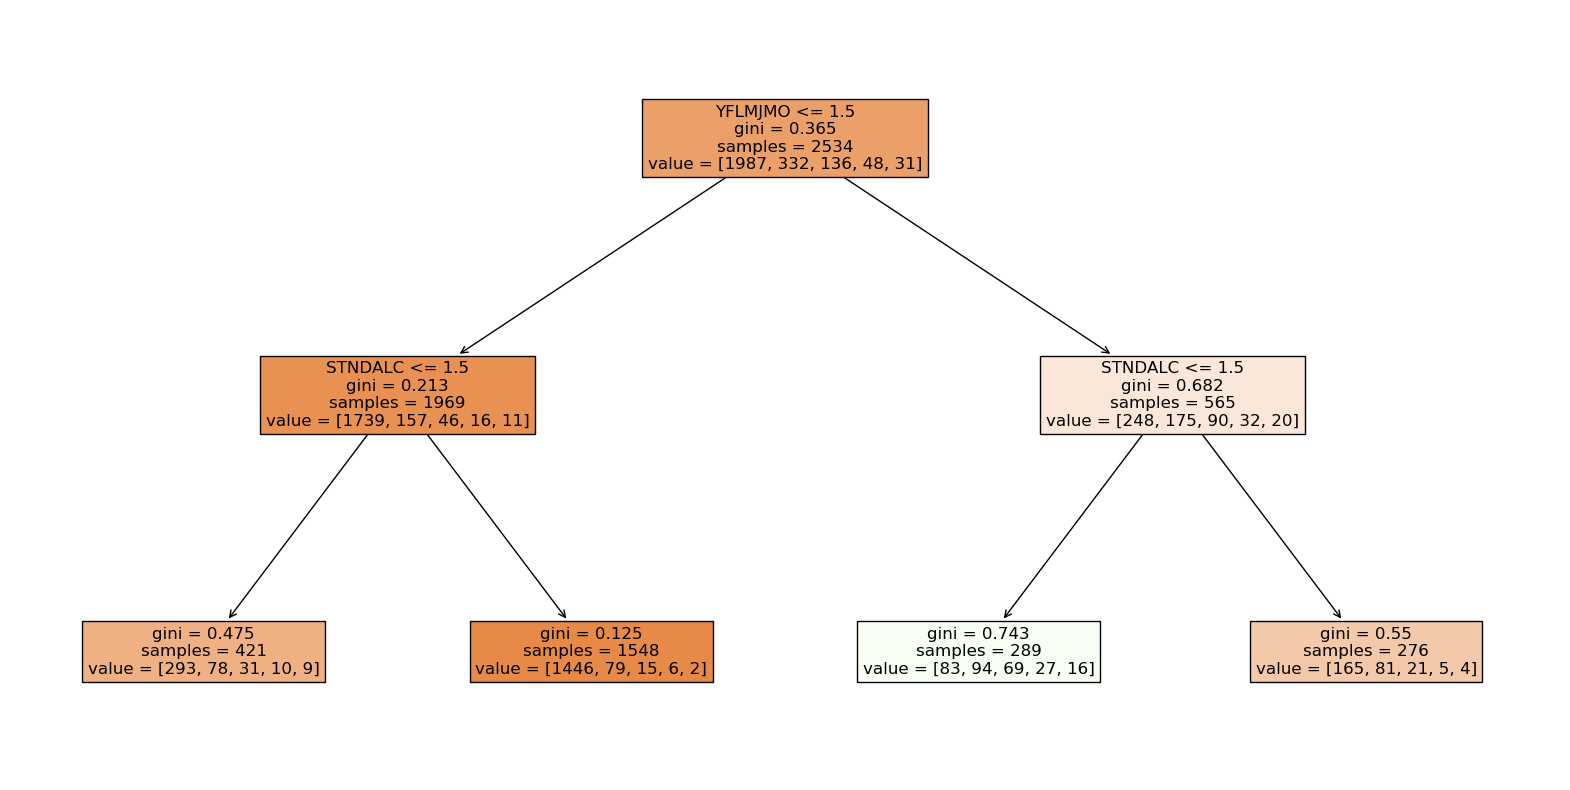

In [ ]:
plt.figure(figsize=(20,10))
plt.title('Pruned Tree')
plot_tree(prune_tree_m
          , filled=True
          , feature_names=X_train.columns
          , label='all'
          , fontsize=12)
plt.show()

Accuracy of decision tree model: 60.88%


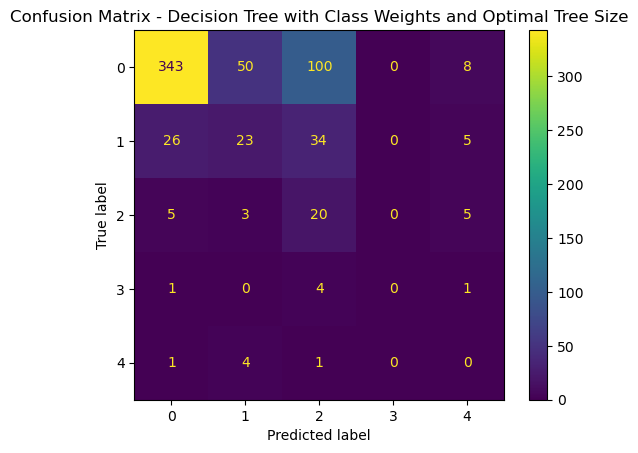

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

tree_m = DecisionTreeClassifier(class_weight='balanced', max_leaf_nodes=4, random_state=1)
tree_m.fit(X_train, y_train)

y_pred_tree = tree_m.predict(X_test)

accuracy = tree_m.score(X_test, y_test)
print("Accuracy of decision tree model: {:.2f}%".format(accuracy * 100))

cm_tree = confusion_matrix(y_test, y_pred_tree)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree)
disp_tree.plot()
plt.title("Confusion Matrix - Decision Tree with Class Weights and Optimal Tree Size")
plt.show()


# RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_features': [5, 10, 15, 20, 'auto', 'sqrt', 'log2']
}

rf_m = RandomForestClassifier(random_state=1)
grid_search = GridSearchCV(estimator=rf_m, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best max_features parameter:", best_params['max_features'])


c:\Users\syeda.fatima\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\syeda.fatima\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\syeda.fatima\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also t

Best max_features parameter: 5


In [ ]:
rf_m = RandomForestClassifier(max_features=5 , random_state = 1)
rf_m.fit(X_train,y_train)

RandomForestClassifier(max_features=5, random_state=1)

In [ ]:
y_pred_rf = rf_m.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 79.50%


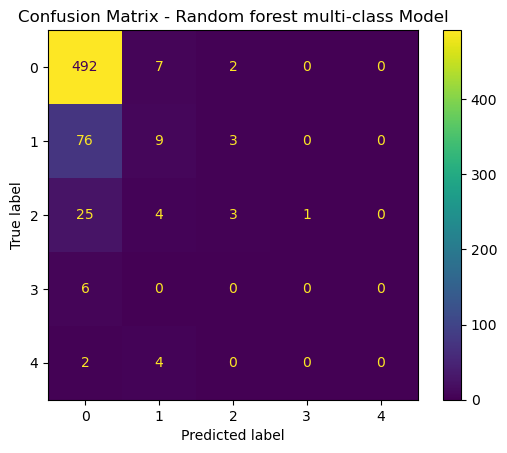

In [ ]:
rf_m_cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_rf))
rf_m_cm.plot()
plt.title("Confusion Matrix - Random forest multi-class Model")
plt.show()

In [ ]:
features_importance = pd.DataFrame({'feature_name': X_train.columns, 'importance': rf_m.feature_importances_})
features_importance = features_importance.sort_values('importance', ascending=False).reset_index(drop=True)
features_importance.head(10)

feature_name  importance
0   EDUSCHGRD2    0.056471
1      STNDALC    0.040401
2      YFLMJMO    0.039615
3     YFLTMRJ2    0.038280
4     FRDMEVR2    0.033848
5      HEALTH2    0.033642
6     NEWRACE2    0.030222
7     FRDMJMON    0.029999
8       INCOME    0.026382
9    EDUSKPCOM    0.025581

In [ ]:
features_importance = pd.DataFrame({'feature_name': X_train.columns, 'importance': rf.feature_importances_})
features_importance = features_importance.sort_values('importance', ascending=False).reset_index(drop=True)
features_importance.head(10)

# boosting

In [ ]:
gb_m = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=1)
gb_m.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=4, random_state=1)

In [ ]:
y_pred = gb_m.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 78.08%


In [ ]:
importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': gb_m.feature_importances_})
importances= importances.sort_values('Importance', ascending=False).reset_index(drop=True)

importances.head()

Feature  Importance
0     YFLMJMO    0.168635
1     STNDALC    0.087046
2  EDUSCHGRD2    0.070949
3    YFLTMRJ2    0.041714
4    FRDMJMON    0.038285

# Regression

In [ ]:
required_columns = demographic_indicators + youth_exp_indicators + ['IRALCAGE']
df_r = df[required_columns]

print(df_r.shape)

(3168, 61)


In [ ]:
df_r['IRALCAGE'].value_counts()

IRALCAGE
991    2331
15      219
14      180
13      137
16      108
12       62
17       36
11       33
10       19
9        12
8        11
7         8
6         7
4         2
2         1
3         1
5         1
Name: count, dtype: int64

In [ ]:
df_r = df_r[df_r['IRALCAGE'] >= 7]
df_r.shape

(3156, 61)

In [ ]:
df_r = df_r[df_r['IRALCAGE'] != 991]
df_r.shape

(825, 61)

In [ ]:
X = df_r.drop('IRALCAGE', axis=1)
y = df_r['IRALCAGE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# decision tree model


In [ ]:
tree = DecisionTreeRegressor(random_state = 1)
tree.fit(X_train,y_train)

MSE = ((y_test - tree.predict(X_test))**2).mean()
print(MSE)

5.350806451612903


In [ ]:
importances = pd.DataFrame({'feature_name': X_train.columns, 'importance': tree.feature_importances_}).sort_values('importance', ascending=False).reset_index(drop=True)
importances.head()

feature_name  importance
0   EDUSCHGRD2    0.383668
1     PRMJEVR2    0.046209
2      TCHGJOB    0.039820
3       INCOME    0.034177
4      SCHFELT    0.028607

pruning

Best tree size:  5


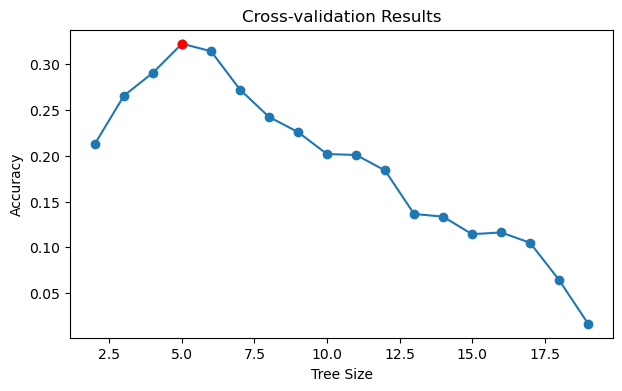

In [ ]:
tree1 = DecisionTreeRegressor(random_state = 1)
tree1.fit(X_train, y_train)

params = {'max_leaf_nodes': range(2, 20)}  
cv_tree1 = GridSearchCV(tree1, params, cv=20)
cv_tree1.fit(X_train, y_train)
cv_results = cv_tree1.cv_results_
best_size = cv_tree1.best_params_['max_leaf_nodes']
best_score = cv_tree1.best_score_

print('Best tree size: ',best_size)

plt.figure(figsize=(7, 4))
plt.plot(cv_results["param_max_leaf_nodes"].data, cv_results["mean_test_score"], 'o-')
plt.plot(best_size, best_score, 'ro-')
plt.xlabel('Tree Size')
plt.ylabel('Accuracy')
plt.title('Cross-validation Results');

In [ ]:
prune_tree = DecisionTreeRegressor(random_state = 1, max_leaf_nodes = best_size)
prune_tree.fit(X_train, y_train)

MSE = ((y_test - prune_tree.predict(X_test))**2).mean()
print(MSE)

2.5254488398977766


In [ ]:
importances = pd.DataFrame({'feature_name': X_train.columns, 'importance': prune_tree.feature_importances_}).sort_values('importance', ascending=False).reset_index(drop=True)
importances.head()

feature_name  importance
0   EDUSCHGRD2    0.929721
1     PRMJEVR2    0.070279
2        IRSEX    0.000000
3     FRDADLY2    0.000000
4     YOATTAK2    0.000000

random forest

In [ ]:
rf_reg = RandomForestRegressor(max_features=20 , random_state = 1)
rf_reg.fit(X_train,y_train)
y_pred_rf = rf_reg.predict(X_test)
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test, y_pred_rf)))

Mean Squared Error: 2.78


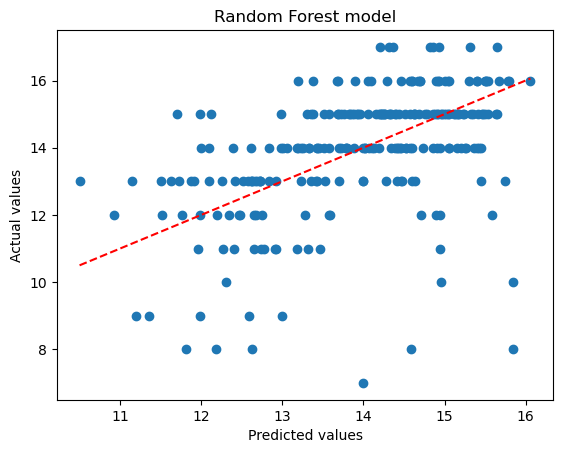

In [ ]:
plt.scatter(y_pred_rf, y_test)
plt.plot([min(y_pred_rf), max(y_pred_rf)], [min(y_pred_rf), max(y_pred_rf)], 'r--')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Random Forest model');

In [ ]:
importances = pd.DataFrame({'feature_name': X_train.columns, 'importance': rf_reg.feature_importances_}).sort_values('importance', ascending=False).reset_index(drop=True)
importances.head()

feature_name  importance
0   EDUSCHGRD2    0.302927
1     YOFIGHT2    0.030462
2     YOATTAK2    0.030217
3      HEALTH2    0.027298
4       INCOME    0.023916

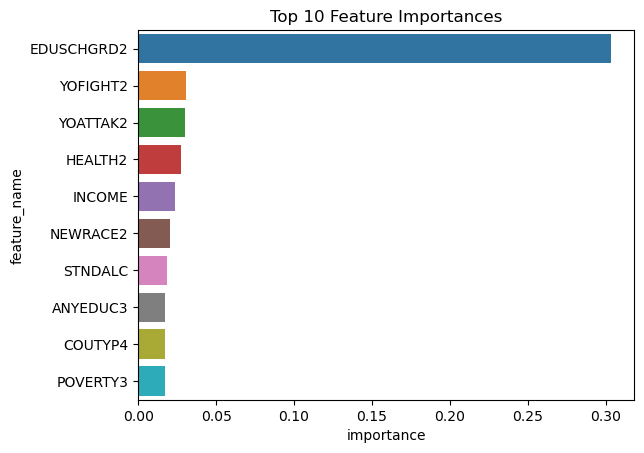

In [ ]:
rf_importance_features = importances.iloc[:10]

sns.barplot(x='importance', y='feature_name', data=rf_importance_features)
plt.title('Top 10 Feature Importances')
plt.show()

boosting

In [ ]:
boost_reg = GradientBoostingRegressor(n_estimators=100, max_depth=4
                                         , random_state=1)
boost_reg.fit(X_train, y_train)

y_pred_boost = boost_reg.predict(X_test)
# find the MSE
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test, y_pred_boost)))

Mean Squared Error: 3.06


In [ ]:
importances = pd.DataFrame({'feature_name': X_train.columns, 'importance': boost_reg.feature_importances_}).sort_values('importance', ascending=False).reset_index(drop=True)
importances.head(10)

feature_name  importance
0   EDUSCHGRD2    0.438941
1     PRMJEVR2    0.030850
2      YOSELL2    0.027600
3     YOATTAK2    0.022530
4       INCOME    0.021348
5     NEWRACE2    0.020591
6     PARCHKHW    0.019623
7     PRPKCIG2    0.019067
8      YOHGUN2    0.018249
9     PRGDJOB2    0.017008